# **CFAR**

Constant False Alarm Rate (CFAR) is used to compute a dynamic threshold to make detections in noisy data. In this notebook we will learn about the most simple form, which is Cell Averaging CFAR or CA-CFAR.

refs:
- https://engineering.purdue.edu/~mrb/resources/AltLectureF/Session_21.pdf
- https://www.mathworks.com/help/phased/ug/constant-false-alarm-rate-cfar-detection.html
- https://apps.dtic.mil/sti/pdfs/ADA429631.pdf

## Background

We are working on a Detection problem where we are aiming to detect a signal in the noise. We can make two simple hypotheses to formally describe the problem:

$$
    H_0 \rightarrow \quad \text{ No signal present } 
    \\
    H_1 \rightarrow \quad \text{ Signal present }
$$

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *
from radar.range_processing import *
from radar.doppler_processing import *
from radar.azimuth_processing import *

%matplotlib inline

In [2]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [3]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:
    for key in h5_obj.keys():
        data_dict.update({key : np.asarray(h5_obj[key])})

In [4]:
data_idx = 28

In [5]:
adc_data = data_dict['radar'][data_idx, ...]

In [6]:
rgb_image = data_dict['rgb'][data_idx, ...]
depth = data_dict['depth'][data_idx, ...]

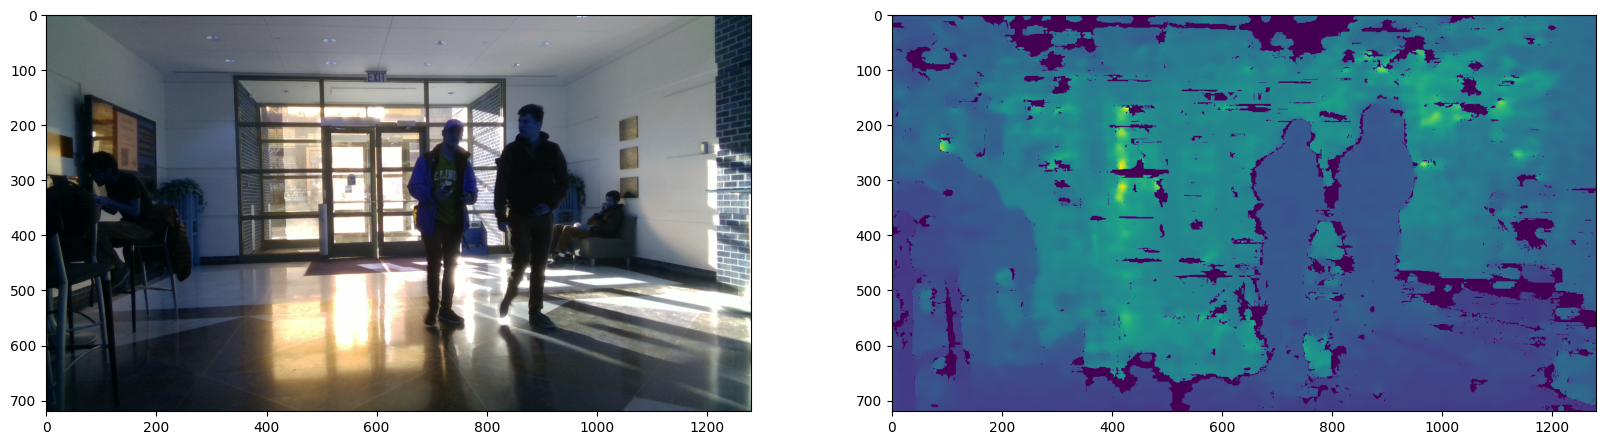

In [7]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_image)
ax[1].imshow(depth);

## Process Data

In [8]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

# perform azimuth processing
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
range_azimuth = capon_spectrum(range_doppler, steering_vector)

## Implement CA-CFAR

Implement Cell Averaging CFAR to detect the targets

For this excercise, the signal of interest will be the range aggregated across all Doppler Bins

In [128]:
x = np.abs(range_doppler).sum(axis=1).sum(axis=1)
# x = np.log(np.abs(range_doppler)).sum(axis=1).sum(axis=1)

# 'notch' the clutter bins
x[:10] = np.median(x[10:]) # - x[10:20].std()

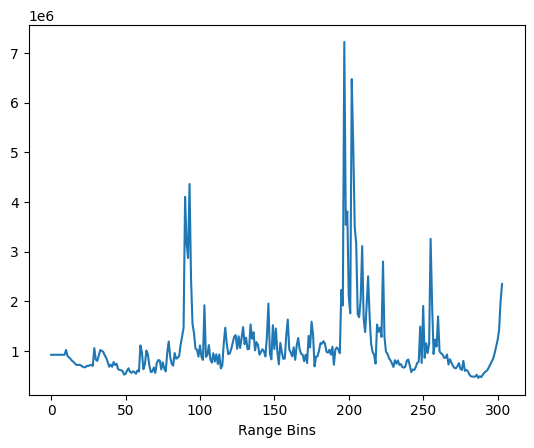

In [129]:
plt.plot(x);
plt.xlabel("Range Bins");

Set CFAR parameters

In [130]:
gaurd_len = 2
train_len = 10

create CFAR kernel to efficiently estimate noise

In [131]:
cfar_kernel = np.ones((1 + 2*gaurd_len + 2*train_len), dtype=float) / (2*train_len)
cfar_kernel[train_len: train_len + (2*gaurd_len) + 1] = 0.

# get gaurd and cell under test for viz
gaurd_cells = np.zeros_like(cfar_kernel)
gaurd_cells[train_len: train_len + (2*gaurd_len) + 1] = cfar_kernel[0]
gaurd_cells[len(gaurd_cells)//2] = 0.

cut = np.zeros_like(cfar_kernel)
cut[len(gaurd_cells)//2] = cfar_kernel[0]

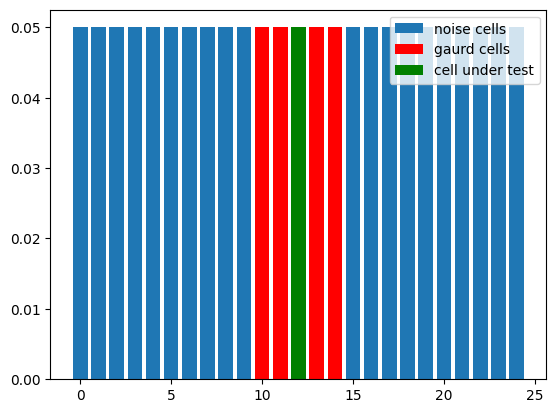

In [132]:
plt.bar(np.arange(len(cfar_kernel)), cfar_kernel, label="noise cells");
plt.bar(np.arange(len(cfar_kernel)), gaurd_cells, color='r', label='gaurd cells');
plt.bar(np.arange(len(cfar_kernel)), cut, color='g', label='cell under test');
plt.legend();

Detection threshold parameter

https://www.mathworks.com/help/phased/ug/constant-false-alarm-rate-cfar-detection.html

In [133]:
p_fa = 0.08 # Probability of False Alarm


a = train_len*(p_fa**(-1/train_len) - 1)
print(f"Threshold scale factor: {a}");

Threshold scale factor: 2.8733329354522374


In [134]:
# a = p_fa**(-1/train_len) - 1

Compute Noise Level and Threshold

In [135]:
from scipy.ndimage import convolve1d

noise_level = convolve1d(np.abs(x), cfar_kernel, mode='nearest')
threshold = noise_level * a

In [136]:
detected = np.abs(x) > threshold

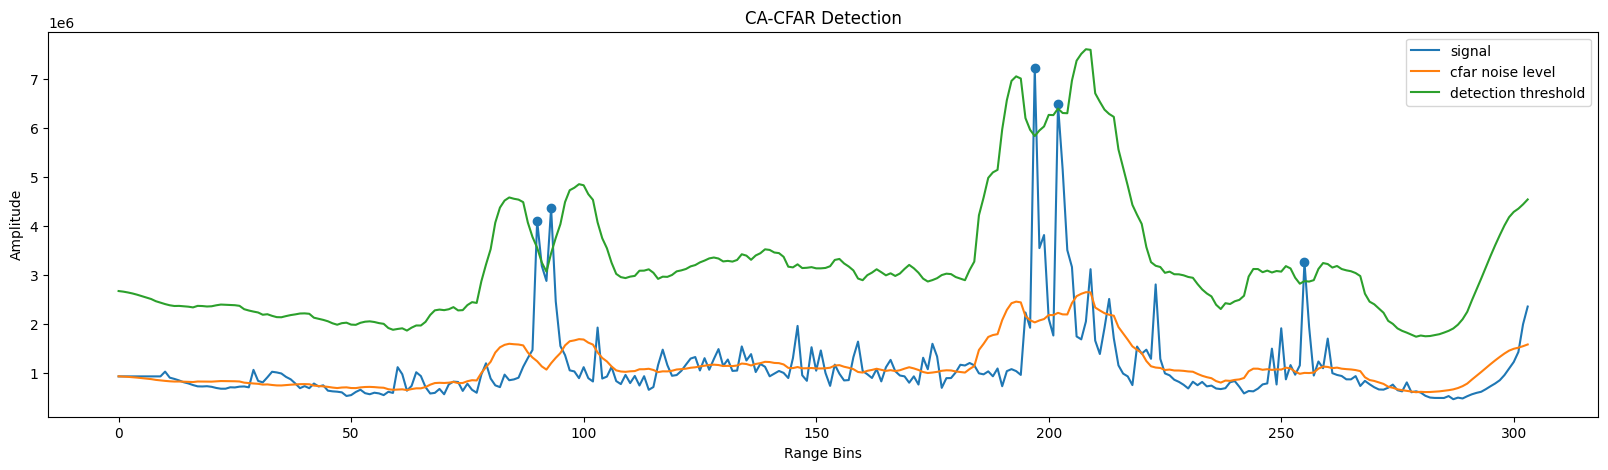

In [137]:
plt.figure(figsize=(20, 5))
plt.plot(np.abs(x), label='signal')
plt.plot(noise_level, label='cfar noise level')
plt.plot(threshold, label='detection threshold')

# display detected targets
plt.scatter(np.arange(0, len(noise_level))[detected], np.abs(x)[detected])

plt.title("CA-CFAR Detection")
plt.xlabel("Range Bins")
plt.ylabel("Amplitude");

plt.legend();

## Derivation (Optional)



In this case, we will assume that the data is Exponentially Distributed 

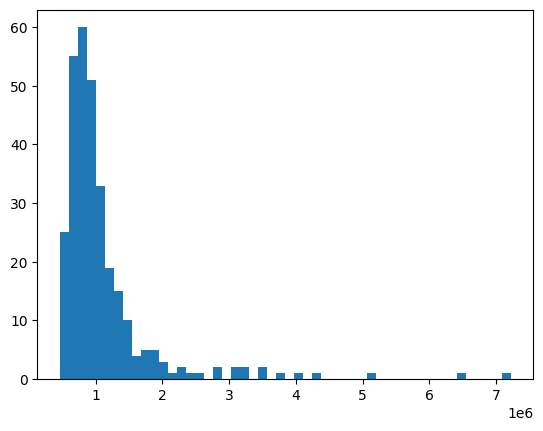

In [94]:
plt.hist(np.abs(x), bins=50);